In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(
    host = "localhost" ,   
    username = "root",
    password = "Bhu@5678",
    database = "ecommerce"
    
)

cur = db.cursor()

BASIC QUERIES

1.List all unique cities where the customers are located

In [20]:

query = """ select distinct(customer_city) from customers"""
cur.execute(query)
data = cur.fetchall()
#print(data)

df = pd.DataFrame(data,columns = ['Cities'])
print(df.head())

                  Cities
0                 franca
1  sao bernardo do campo
2              sao paulo
3        mogi das cruzes
4               campinas


2.count the no.of orders placed in the year 2017

In [21]:

query = """ select count(order_id) from orders where year(order_purchase_timestamp)='2017' """
cur.execute(query)
data = cur.fetchall()
print("Total Orders in 2017 are:",data[0][0])

Total Orders in 2017 are: 90202


3.Find the total sales per category

In [22]:

query = """ select pr.product_category,round(sum(payment_value),2) sales
            from products  pr
            join order_items oi on pr.product_id = oi.product_id
            join payments p on p.order_id = oi.order_id 
            group by pr.product_category """
cur.execute(query)
data = cur.fetchall()
#data

df = pd.DataFrame(data,columns = ['Product_category','Total_Sales'])
df

,Product_category,Total_Sales
0,perfumery,4053909.28
1,Furniture Decoration,11441411.13
2,telephony,3895056.41
3,bed table bath,13700429.37
4,automotive,6818354.65
...,...,...
69,cds music dvds,9595.44
70,La Cuisine,23308.24
71,Fashion Children's Clothing,6285.36
72,PC Gamer,17395.44


4.Calculate the percentage of orders that were paid in installments.

In [23]:
query = """ select (sum(case when payment_installments >=1 then 1 else 0 end) * 100) / count(order_id) Percentage
            from payments"""
cur.execute(query)
data = cur.fetchall()
data

[(Decimal('99.9981'),)]

5.count the no.of customers from each state

<Axes: xlabel='State', ylabel='Total_Customers'>

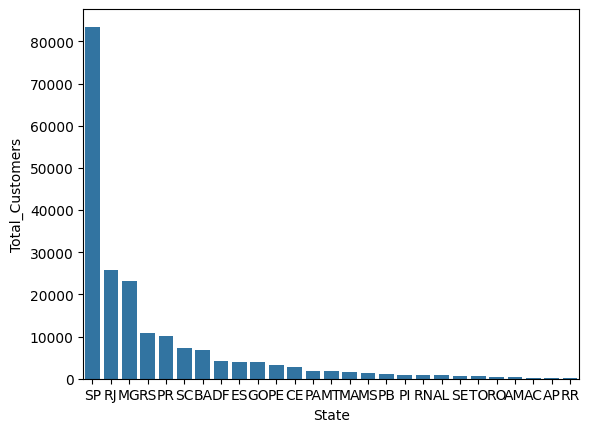

In [24]:

query = """ select customer_state, count(customer_id) Total_customers from customers group by customer_state """
cur.execute(query)
data = cur.fetchall()
#data
df = pd.DataFrame(data, columns = ['State','Total_Customers'])
#print(df)
df = df.sort_values(by = 'Total_Customers',ascending=False)
sns.barplot(df,x = 'State', y = 'Total_Customers')


INTERMEDIATE QUERIES

1. Calculate the number of orders per month in 2018

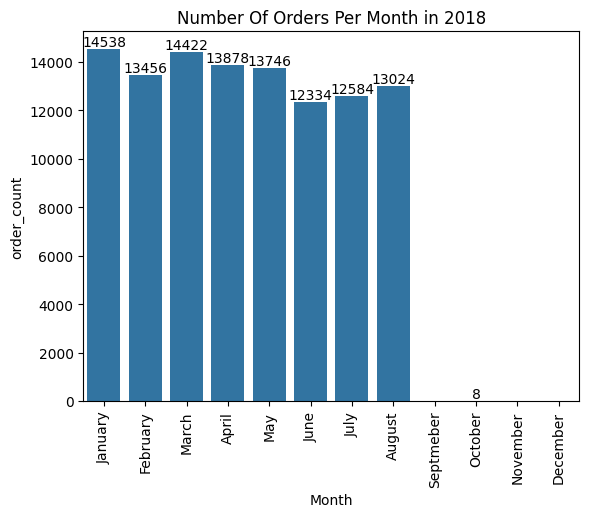

In [26]:

query = """ select monthname(order_purchase_timestamp) Month , count(order_id) Number_of_Orders
            from orders where year(order_purchase_timestamp) = 2018 group by Month """
cur.execute(query)
data = cur.fetchall()
#data

df = pd.DataFrame(data, columns = ['Month','order_count'])
o = ["January","February","March","April","May","June","July","August","Septmeber","October","November","December"]
res = sns.barplot(df, x = "Month", y = "order_count", order = o)

plt.xticks(rotation = 90)
res.bar_label(res.containers[0]) # to show the value of the bar
plt.title("Number Of Orders Per Month in 2018")
plt.show()


2.Find the average number of products per order grouped by customer city

In [34]:

query = """ with count_per_order as
                ( select order_id, count(product_id) product_count
                from order_items 
                group by order_id)
                select customer_city, avg(co.product_count) avg_products_per_order
                from  customers c 
                join orders o on o.customer_id = c.customer_id
                join count_per_order co on co.order_id = o.order_id
                group by customer_city order by avg_products_per_order desc """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data,columns = ['City','Avg no.of Products'])
print(df.head())

             City Avg no.of Products
0  padre carvalho            14.0000
1     celso ramos            13.0000
2           datas            12.0000
3   candido godoi            12.0000
4  matias olimpio            10.0000


3.Calculate the percentage of toatl revenue contributed by each product category

In [28]:

query = """ select pr.product_category ,
            round((sum(p.payment_value)/(select sum(payment_value) from payments))*100,2)sales_percentage
            from products  pr
            join order_items oi on pr.product_id = oi.product_id
            join payments p on p.order_id = oi.order_id 
            group by pr.product_category order by sales_percentage desc  """
cur.execute(query)
data = cur.fetchall()
#data

df = pd.DataFrame(data, columns = ['Product_category','Sales_percentage'])
df

,Product_category,Sales_percentage
0,bed table bath,42.79
1,HEALTH BEAUTY,41.41
2,computer accessories,39.61
3,Furniture Decoration,35.73
4,Watches present,35.71
...,...,...
69,PC Gamer,0.05
70,House Comfort 2,0.04
71,cds music dvds,0.03
72,Fashion Children's Clothing,0.02


4.Identify the correlation between the product price and the no.of times the product has been purchased

In [ ]:

query = """ select pr.product_category, count(oi.product_id) Purchase_count , round(avg(oi.price),2) price
            from order_items oi 
            join products pr on pr.product_id = oi.product_id
            group by pr.product_category """
cur.execute(query)
data = cur.fetchall()
#data
df = pd.DataFrame(data,columns = ['Product','Order_Count','Price'])
#print(df)

#finding correlation coefficient
arr1 = np.array(df['Price'])
arr2 = np.array(df['Order_Count'])

c = np.corrcoef(arr1,arr2)
print("The correlation between the price and the no.of times the product has been purchased is ",c[0,1])

                            Product  Order_Count   Price
0                     HEALTH BEAUTY        38680  130.16
1                     sport leisure        34564  114.34
2                        Cool Stuff        15184  167.36
3              computer accessories        31308  116.51
4                   Watches present        23964  201.14
..                              ...          ...     ...
69                          flowers          132   33.64
70  Kitchen portable and food coach           60  264.57
71       CITTE AND UPHACK FURNITURE          152  114.95
72                  House Comfort 2          120   25.34
73                   cds music dvds           56   52.14

[74 rows x 3 columns]
The correlation between the price and the no.of times the product has been purchased is  -0.10631514167157562


5.Calculate the total revenue generated by each seller and rank them by revenue

In [ ]:

query = """ with Revenue_Per_Seller as (
            select oi.seller_id, round(sum(payment_value),2) total_revenue
            from  order_items oi 
            join payments p on p.order_id = oi.order_id
            group by oi.seller_id)
            select seller_id, total_revenue,
            dense_rank() over (order by total_revenue desc)  as Seller_Rank
            from Revenue_Per_Seller"""
cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data,columns = ['Seller_Id','Revenue','Seller_Rank'])
print(df)


                             Seller_Id     Revenue  Seller_Rank
0     7c67e1448b00f6e969d365cea6b010ab  2028667.63            1
1     1025f0e2d44d7041d6cf58b6550e0bfa  1232888.16            2
2     4a3ca9315b744ce9f8e9374361493884  1204981.08            3
3     1f50f920176fa81dab994f9023523100  1161013.68            4
4     53243585a1d6dc2643021fd1853d8905  1139612.32            5
...                                ...         ...          ...
3090  ad14615bdd492b01b0d97922e87cb87f       76.84         3076
3091  702835e4b785b67a084280efca355756       74.24         3077
3092  4965a7002cca77301c82d3f91b82e1a9       65.44         3078
3093  77128dec4bec4878c37ab7d6169d6f26       60.88         3079
3094  cf6f6bc4df3999b9c6440f124fb2f687       48.88         3080

[3095 rows x 3 columns]


,Seller_Id,Revenue,Seller_Rank
0,7c67e1448b00f6e969d365cea6b010ab,2028667.63,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,1232888.16,2
2,4a3ca9315b744ce9f8e9374361493884,1204981.08,3
3,1f50f920176fa81dab994f9023523100,1161013.68,4
4,53243585a1d6dc2643021fd1853d8905,1139612.32,5


ADVANCED QUERIES

1.Calculate the moving average of order values for each customer over their order history

In [30]:

query = """select customer_id, order_purchase_timestamp, payment,
            avg(payment) over(partition by customer_id order by order_purchase_timestamp
            rows between 2 preceding and current row) as mov_avg
            from
            (select orders.customer_id, orders.order_purchase_timestamp, 
            payments.payment_value as payment
            from payments join orders
            on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
#data
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
...,...,...,...,...
415539,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
415540,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415541,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415542,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


2.Calculate the cumulative sales per month for each year.

In [33]:

query = """ with Sales_Per_Month as
            (select year(o.order_purchase_timestamp) Year ,month(o.order_purchase_timestamp) Month,
            round(sum(p.payment_value),2) Payment
            from orders o
            join payments p on p.order_id = o.order_id
            group by Year,Month order by Year,Month)
            select Year,Month, Payment, sum(Payment) over(order by Year,Month) Cumulative_Payment
            from Sales_Per_Month"""

cur.execute(query)
data = cur.fetchall()
#data
df = pd.DataFrame(data,columns = ['Year','Month','Sales','Cumulative_Sales'])
df

,Year,Month,Sales,Cumulative_Sales
0,2016,9,1008.96,1008.96
1,2016,10,236361.92,237370.88
2,2016,12,78.48,237449.36
3,2017,1,553952.16,791401.52
4,2017,2,1167632.04,1959033.56
5,2017,3,1799454.40,3758487.96
6,2017,4,1671152.12,5429640.08
7,2017,5,2371675.28,7801315.36
8,2017,6,2045105.52,9846420.88
9,2017,7,2369531.68,12215952.56


3.Calculate the year-over-year growth rate of total sales.

In [32]:

query = """ select years,Sales, 
            ((Sales-lag(Sales,1,0)over(order by Years))/lag(Sales,1,0)over(order by Years))*100  Sales_Growth
            from(select year(o.order_purchase_timestamp) Years , round(sum(p.payment_value),2) Sales
            from orders o 
            join payments p on p.order_id = o.order_id
            group by Years order by Years) as a"""

cur.execute(query)
data = cur.fetchall()
#data
df = pd.DataFrame(data,columns = ['Years','Sales','Sales_Growth'])
df


,Years,Sales,Sales_Growth
0,2016,237449.36,NaN
1,2017,28998986.91,12112.703757
2,2018,34799052.21,20.000924


4.Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [10]:
 
query = """ with a as 
            (select customer_id, min(order_purchase_timestamp) first_order
            from orders
            group by customer_id order by customer_id),
            b as
            (select a.customer_id, first_order ,count(distinct orders.order_purchase_timestamp) orders_within_6mon
            from a 
            join orders on orders.customer_id = a.customer_id
            and orders.order_purchase_timestamp > first_order
            and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
            group by a.customer_id)
            select 100*(count(a.customer_id)/count(b.customer_id))
            from a left join b on a.customer_id = b.customer_id"""

cur.execute(query)
data = cur.fetchall()
data


[(None,)]

5.Identify the top 3 customers who spent the most money in each year.

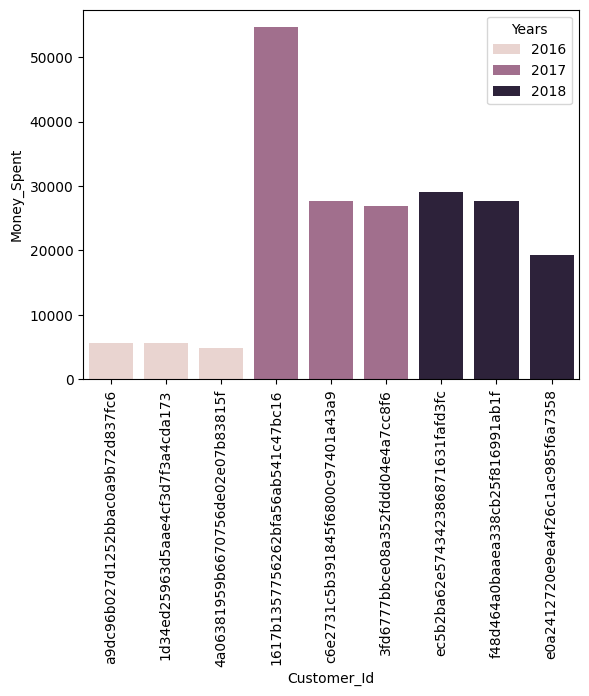

In [31]:
query = """ with ranked_customers as
            (select Years,Customer_id,Money_Spent,
            rank() over(partition by years order by Money_Spent desc) as Top_Customers 
            from
            (select o.customer_id,year(o.order_purchase_timestamp) Years ,sum(p.payment_value) Money_Spent
            from orders o
            join payments p on p.order_id = o.order_id
            group by o.customer_id,years
            order by years, Money_Spent desc) as a
            )
            select * from ranked_customers
            where Top_Customers <=3"""
cur.execute(query)
data = cur.fetchall()
#data

df = pd.DataFrame(data, columns = ['Years','Customer_Id','Money_Spent','Rank'])
df
sns.barplot(df,x = 'Customer_Id', y = 'Money_Spent', hue = 'Years')
plt.xticks(rotation = 90)
plt.show()
